# GPU Optimization

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

You should consider upgrading via the 'E:\Projects\Transfer Learning\tranferLearning\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Imports

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Loading Dataset

In [6]:
data_dir = 'Photos'
train_dir = 'seg_train/seg_train'
prediction_dir = 'seg_pred/seg_pred'
test_dir = 'seg_test/seg_test'

In [7]:
image_size = (180,180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                directory=os.path.join(data_dir, train_dir),
                validation_split=None,
                seed=100,
                image_size=image_size,
                batch_size=batch_size
                )

Found 14034 files belonging to 6 classes.


In [8]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
                directory=os.path.join(data_dir, test_dir),
                validation_split=None,
                seed=100,
                image_size=image_size,
                batch_size=batch_size
                )

Found 3000 files belonging to 6 classes.


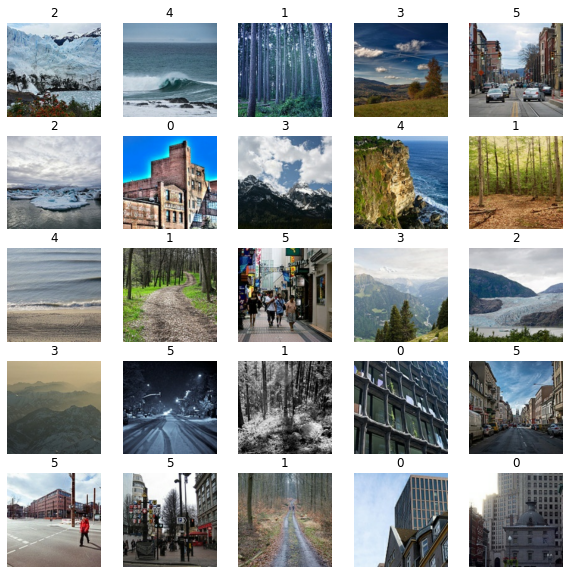

In [9]:
# Looking at a few images in the train dataset

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Loading InceptionV3 model and Performing Transfer Learning

In [10]:
# :Loading InceptionV3 model with pre-training weights from ImageNet, output classes as 6 and activation as softmax

base_model = tf.keras.applications.InceptionV3(
                        include_top=False,
                        weights="imagenet",
                        input_shape=image_size+(3,),
                        classes=6,
                        classifier_activation="softmax"
                        )

In [11]:
# Number of Layers in InceptionV3 Model
len(base_model.layers)

311

In [12]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 89, 89, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 89, 89, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [13]:
# Freezing the Base Model
base_model.trainable = False

In [14]:
model = tf.keras.Sequential([ 
        base_model,   
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')
    ])

In [15]:
# Double Checking if base model's layers are trainable
trainable_base_layers = 0
for layer in base_model.layers:
    trainable_base_layers = trainable_base_layers + layer.trainable
    
print("Number of Trainable Layers -", trainable_base_layers)

Number of Trainable Layers - 0


In [16]:
# Compiling Model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics = ["accuracy"])

In [17]:
# Fitting Model
callbacks = [EarlyStopping(patience=5, monitor='val_loss')]
history = model.fit(train_ds, validation_data=validation_ds, epochs=25, callbacks=callbacks)

Epoch 1/25
439/439 [==============================] - 40s 73ms/step - loss: 1.9271 - accuracy: 0.4627 - val_loss: 1.1317 - val_accuracy: 0.5623
Epoch 2/25
439/439 [==============================] - 28s 65ms/step - loss: 1.1384 - accuracy: 0.5609 - val_loss: 1.0807 - val_accuracy: 0.5867
Epoch 3/25
439/439 [==============================] - 28s 65ms/step - loss: 1.0470 - accuracy: 0.5959 - val_loss: 1.0308 - val_accuracy: 0.6130
Epoch 4/25
439/439 [==============================] - 28s 65ms/step - loss: 0.9945 - accuracy: 0.6233 - val_loss: 1.0451 - val_accuracy: 0.6023
Epoch 5/25
439/439 [==============================] - 29s 65ms/step - loss: 0.9349 - accuracy: 0.6458 - val_loss: 1.0188 - val_accuracy: 0.6117
Epoch 6/25
439/439 [==============================] - 29s 65ms/step - loss: 0.8838 - accuracy: 0.6666 - val_loss: 1.0357 - val_accuracy: 0.6233
Epoch 7/25
439/439 [==============================] - 29s 65ms/step - loss: 0.8366 - accuracy: 0.6863 - val_loss: 1.0177 - val_accuracy:

Text(0, 0.5, 'Accuracy')

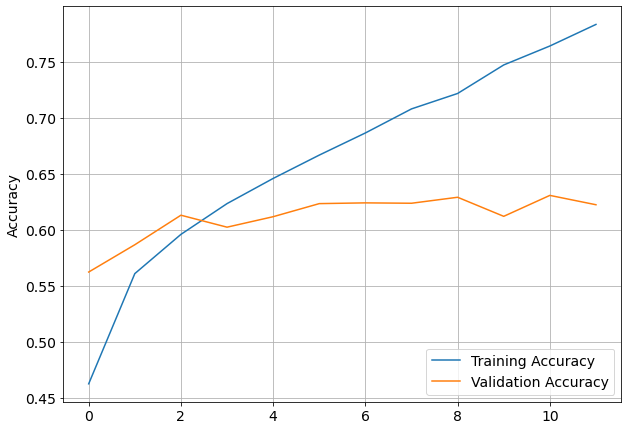

In [18]:
# store results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
  
  
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')

In [19]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [20]:
# Total 310 layers
# Let's keep 236 layers - trainable
# From 237 - Non-trainable
for layer in model.layers[:237]:
   layer.trainable = False
for layer in model.layers[237:]:
   layer.trainable = True

In [21]:
# Compiling model with low learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics = ["accuracy"])

In [22]:
# Fitting Model again but this time with Early Stopping
callbacks = [EarlyStopping(patience=3, monitor='val_loss')]
history = model.fit(train_ds, validation_data=validation_ds, epochs=6, callbacks=callbacks)

Epoch 1/6
439/439 [==============================] - 32s 67ms/step - loss: 0.5557 - accuracy: 0.7920 - val_loss: 1.3133 - val_accuracy: 0.6223
Epoch 2/6
439/439 [==============================] - 28s 64ms/step - loss: 0.5572 - accuracy: 0.7902 - val_loss: 1.3133 - val_accuracy: 0.6223
Epoch 3/6
439/439 [==============================] - 28s 64ms/step - loss: 0.5500 - accuracy: 0.7941 - val_loss: 1.3133 - val_accuracy: 0.6223
Epoch 4/6
439/439 [==============================] - 28s 64ms/step - loss: 0.5546 - accuracy: 0.7936 - val_loss: 1.3133 - val_accuracy: 0.6223
Epoch 5/6
439/439 [==============================] - 28s 64ms/step - loss: 0.5563 - accuracy: 0.7910 - val_loss: 1.3133 - val_accuracy: 0.6223


# Predictions

Photos\seg_pred/seg_pred\10012.jpg
1/1 [==============================] - 2s 2s/step
Class: 0 
Class name: Buildings 
Class probability: 0.62120074


(-0.5, 149.5, 149.5, -0.5)

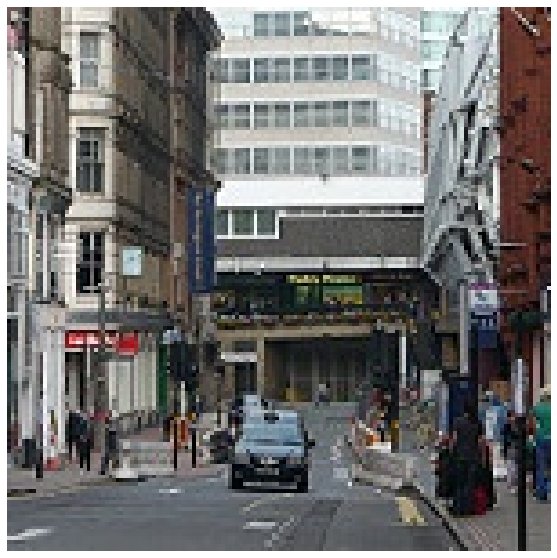

In [23]:
# Prediction on a single image from pred set
class_names = sorted(os.listdir(os.path.join(data_dir, train_dir)))

pred_dir_path = os.path.join(data_dir, prediction_dir)

img_names = os.listdir(pred_dir_path)
img_path = os.path.join(pred_dir_path, img_names[3])

print(img_path)

img = tf.keras.preprocessing.image.load_img(
    img_path, target_size=image_size
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]

print("Class:", np.argmax(score), "\nClass name:", class_names[np.argmax(score)].title(), "\nClass probability:", np.max(score))

# Display image
plt.figure(figsize=(10, 10))
plt.imshow(mpimg.imread(img_path))
plt.axis("off")